In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Geod
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import graph_tool.all as gt
import networkx as nx
import pickle
from math import ceil

In [110]:
df = pd.read_csv('./VF_data/pandemos_tra_tapas_modell.csv')

In [111]:
# select qunatile above/below 1/95% quantile
print(df.shape)
lower_bound = df.start_time_min.quantile(.01)
upper_bound = df.start_time_min.quantile(.95)
df = df[df.start_time_min < upper_bound]
df = df[df.start_time_min > lower_bound]
df.shape

(13578537, 15)


(12759384, 15)

In [112]:
def get_geodesis(row, lon, lat, node_dict, geod):
    id, ts, ta = int(row.p_id), int(row.start_time_min), int(row.activity_duration_min)
    travel_time = ceil(row.travel_time_sec / 60)
    geodesis = np.array(geod.npts(row.lon_start, row.lat_start, row.lon_end, row.lat_end, travel_time, initial_idx=0, terminus_idx=0))

    # travel
    lon[node_dict[id]][ts: ts + travel_time] = geodesis[:, 0]
    lat[node_dict[id]][ts: ts + travel_time] = geodesis[:, 1]
    # pause
    lon[node_dict[id]][ts + travel_time: ts + travel_time + ta] = geodesis[-1, 0]
    lat[node_dict[id]][ts + travel_time: ts + travel_time + ta] = geodesis[-1, 1]

def calculate_trajectories(df, n):
    geod = Geod("+ellps=WGS84")

    # select n nodes
    nnodes = df.p_id.unique()
    np.random.shuffle(nnodes)
    nnodes = nnodes[:n]
    df_nnodes = df[df.p_id.isin(nnodes)]

    # assign trajectories
    tmax = (df_nnodes.activity_start_min + df_nnodes.activity_duration_min).max()- df_nnodes.start_time_min.min()
    df_nnodes.start_time_min = df_nnodes.start_time_min - df_nnodes.start_time_min.min()
    node_dict = {node: i for i, node in enumerate(nnodes)}
    node_dict = dict(zip(nnodes, range(n)))
    lon = np.empty((n, tmax))
    lon.fill(np.nan)
    lat = lon.copy()

    df_nnodes.apply(get_geodesis, args=(lon, lat, node_dict, geod), axis=1)  

    return lon.T, lat.T

X, Y = calculate_trajectories(df, 1_000)
X.shape

/tmp/ipykernel_3828812/84676553.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nnodes.start_time_min = df_nnodes.start_time_min - df_nnodes.start_time_min.min()


(1412, 1000)

1412
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275

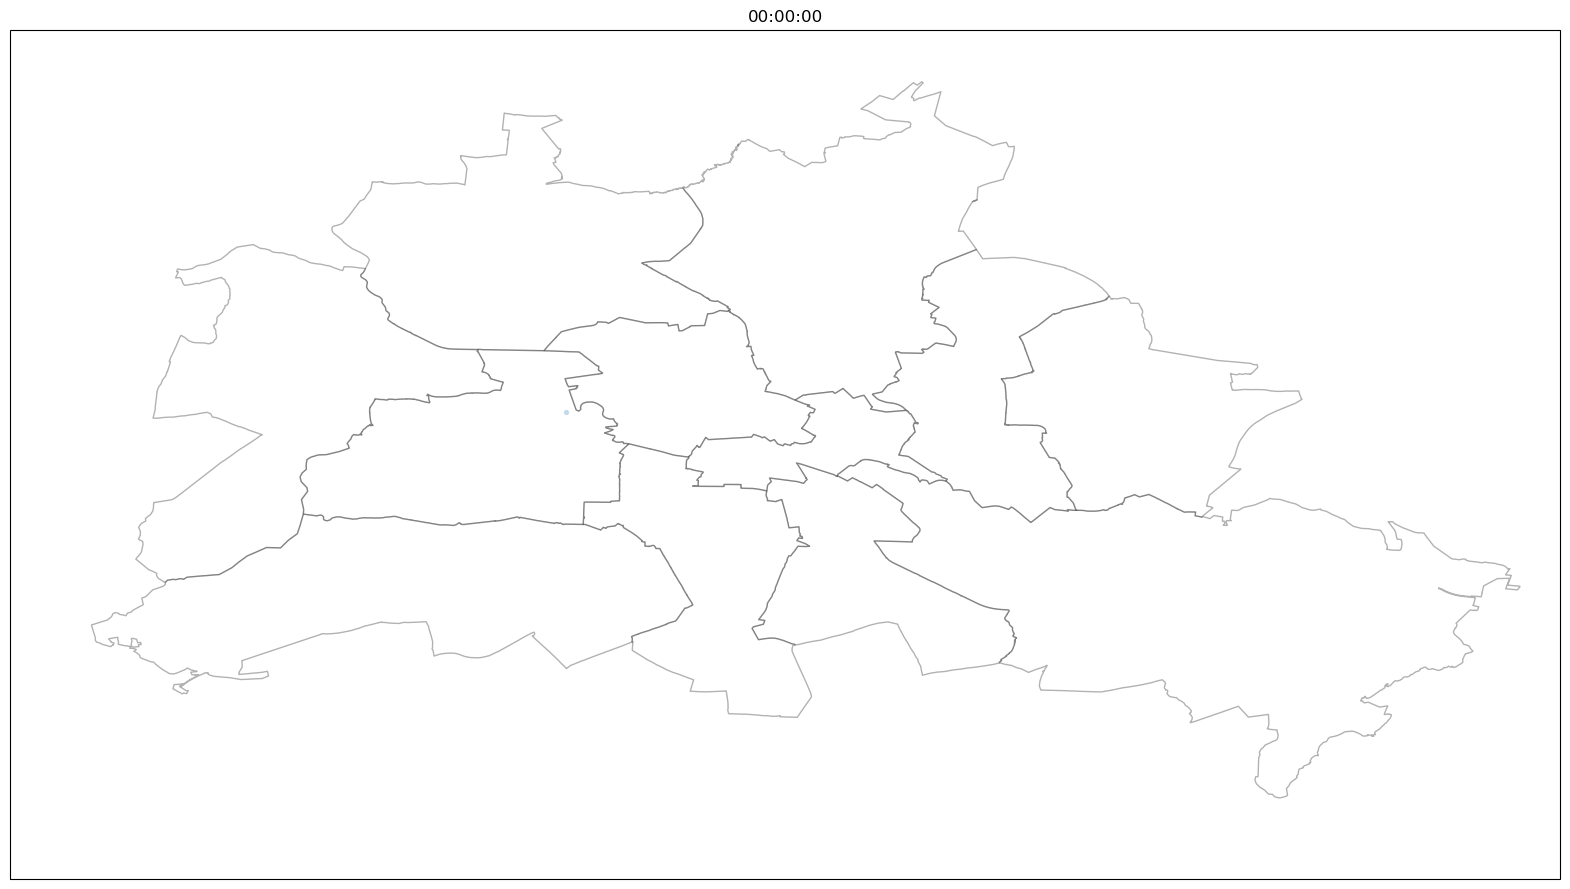

In [114]:
# make animation

def setup_plot():
    fname = './shape_files/Berlin/bezirksgrenzen.shp'

    adm1_shapes = list(shpreader.Reader(fname).geometries())

    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

    ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                    edgecolor='black', facecolor='white', alpha=.3)

    ax.set_extent([13.05, 13.78, 52.3, 52.7], ccrs.PlateCarree())

    return fig, ax

fig, ax = setup_plot()
scat = ax.scatter(X[0], Y[0], s=8, alpha=.3, transform=ccrs.PlateCarree())
print(len(X))
d, h, m = 0, 0, 0

def animation_function(i):
    d = int(np.floor(i/1440)) # 60*24=1440 minutes per day
    h = int(np.floor(i/60) - 24*d)
    m = int(i - 60*h - 1440*d)

    print(i)
    data = np.stack((X[i], Y[i])).T
    scat.set_offsets(data)
    ax.set_title(f'{str(d).zfill(2)}:{str(h).zfill(2)}:{str(m).zfill(2)}')

anim = FuncAnimation(fig, animation_function, frames=len(X), interval=1)
anim.save('berlin.gif', fps=50)

##### Wo befinden sich die Locations mit den meisten Besuchern?
##### Wo befinden sich die einzelnen Haushalte?

In [16]:
def find_loc_most_visits(df, first_n= 1000):
    # Return first n locations with the most visits
    # A visit is counted, if its the end of a trajectory
    dfg = df.groupby('loc_id_end')
    dfg.size()
    df_locations = dfg[['lon_end', 'lat_end']].first()
    df_locations['visits'] = dfg.size()
    loc_lon_lat_size = df_locations.sort_values('visits', ascending=False)[:first_n].to_numpy()
    print(loc_lon_lat_size[:4])

    fig, ax = setup_plot()
    ax.set_title(f'{first_n}-most visited location', fontsize=20)
    sc = ax.scatter(loc_lon_lat_size[:, 0], loc_lon_lat_size[:, 1], loc_lon_lat_size[:, 2]/100, c='blue', alpha=.7, edgecolors='black')
    plt.legend(*sc.legend_elements("sizes", num=4), title='visits in units of 100', title_fontsize=15)
    plt.tight_layout()
    plt.savefig(f'locations_berlin_{first_n}.png')
    plt.close()

find_loc_most_visits(df, 10_000)

[[1.33291608e+01 5.25149479e+01 7.86470000e+04]
 [1.33054974e+01 5.25096848e+01 7.14140000e+04]
 [1.33346602e+01 5.25935055e+01 5.92370000e+04]
 [1.35569618e+01 5.25600620e+01 4.74050000e+04]]


In [17]:
def find_households(first_n=None):
    household_lon_lat = df.groupby('p_id')[['lon_end', 'lat_end']].last().to_numpy()
    fig, ax = setup_plot()

    ax.set_title('Berlin household distribution', fontsize=20)
    ax.scatter(household_lon_lat[:first_n, 0], household_lon_lat[:first_n, 1], s=1, alpha=.5)

    plt.tight_layout()
    plt.savefig(f'berlin_household_distribution_first{first_n}.png')
    plt.close()

find_households()

##### Effizientes generieren der Netzwerke

In [23]:
df['activity_end_min'] = df['activity_start_min'] + df['activity_duration_min']
df.activity_end_min

0            651
1            897
2            916
3           1224
4           1215
            ... 
13578532    1505
13578533    1231
13578534    1293
13578535    1105
13578536    1172
Name: activity_end_min, Length: 13578537, dtype: int64

In [27]:
contacts = []

def get_contacts(grp):
    print(grp)
    print(grp['activity_end_min'].apply(lambda end: grp['activity_start_min'] < end))
    print('\n\n\n')
    

df.groupby('loc_id_end')[['p_id', 'activity_start_min', 'activity_end_min']].apply(get_contacts)

               p_id  activity_start_min  activity_end_min
13578525  103604315                1000              1193
13578527  103604316                 972               982
13578529  103604316                1043              1298
13578532  103604316                1503              1505
13578534  103604317                1253              1293
13578536  103604318                1124              1172
          13578525  13578527  13578529  13578532  13578534  13578536
13578525      True      True      True     False     False      True
13578527     False      True     False     False     False     False
13578529      True      True      True     False      True      True
13578532      True      True      True      True      True      True
13578534      True      True      True     False      True      True
13578536      True      True      True     False     False      True




               p_id  activity_start_min  activity_end_min
13578506  103604310                1105          

In [47]:
with open(f'./pickles/simple_edges_{0}.pkl', 'rb') as f:
    edge_dict = pickle.load(f)

sub_dict = {}
for key in [103604317, 103604316, 103604315]:
    sub_dict[key - 103604300] = -edge_dict[103604317]+  103604300

sub_dict

{17: array([3436022,  242019,  156320,  150933,  114335,   95383,   90797,
          78285,   63337,   62956,   48368,   48265,   47572,   34477,
          29541,    7820,     -17]),
 16: array([3436022,  242019,  156320,  150933,  114335,   95383,   90797,
          78285,   63337,   62956,   48368,   48265,   47572,   34477,
          29541,    7820,     -17]),
 15: array([3436022,  242019,  156320,  150933,  114335,   95383,   90797,
          78285,   63337,   62956,   48368,   48265,   47572,   34477,
          29541,    7820,     -17])}

In [35]:
G_nx = nx.Graph(sub_dict)

In [62]:
G_gt = gt.Graph()
G_gt.add_edge_list([(10, 1)])

In [12]:
# Your sample DataFrame
df = pd.DataFrame({'p_id': [0, 0, 0, 1, 2, 2, 3],
                   'start': [0, 100, 200, 50, 20, 40, 150],
                   'end': [50, 110, 205, 80, 25, 50, 170]})

# Define a function to generate the required array
def generate_array(row):
    return np.arange(row['start'], row['end'] + 1)

def get_position(grp):
    indices = np.concatenate(grp.to_numpy())
    print(grp.name)
    print(indices)

# Apply the function to each row in the DataFrame
result = df.apply(generate_array, axis=1)

# Group the arrays by 'p_id' and convert them into NumPy arrays
result.groupby(df['p_id']).apply(get_position)#.reset_index(name='result')

result

0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50 100 101 102
 103 104 105 106 107 108 109 110 200 201 202 203 204 205]
1
[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80]
2
[20 21 22 23 24 25 40 41 42 43 44 45 46 47 48 49 50]
3
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170]


0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
1    [100, 101, 102, 103, 104, 105, 106, 107, 108, ...
2                       [200, 201, 202, 203, 204, 205]
3    [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 6...
4                             [20, 21, 22, 23, 24, 25]
5         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
6    [150, 151, 152, 153, 154, 155, 156, 157, 158, ...
dtype: object